In [1]:
%pylab inline
from sklearn import linear_model
import cv2
from math import exp
from matplotlib import pyplot as plt
from skimage import measure

Populating the interactive namespace from numpy and matplotlib


<h2>Initial Parameters</h2>


Import simulated images

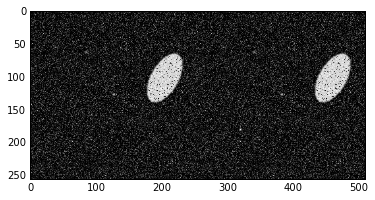

In [2]:
R = cv2.imread('./Images/ReferenceImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
N = cv2.imread('./Images/NewImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
row_r, col_r = R.shape
row_n, col_n = N.shape
vis = np.concatenate((R, N), axis=1)
plt.imshow(vis, cmap="Greys_r")

Known image parameters (from simulation)

In [3]:
# Auxiliary functions to calculate PSFs
def gaussian(x, mu, sigma):
    return exp( -(((x-mu)/(sigma))**2)/2.0 )

def get_convolution_matrix(kernel_radius, sigma):
    # compute the kernel elements
    hkernel = [gaussian(x, kernel_radius, sigma) for x in range(2*kernel_radius+1)]
    vkernel = [x for x in hkernel]
    kernel2d = [[xh*xv for xh in hkernel] for xv in vkernel]
   
    # normalize the kernel elements
    kernelsum = sum([sum(row) for row in kernel2d])
    kernel2d = [[x/kernelsum for x in row] for row in kernel2d]
    
    return array(kernel2d)

In [4]:
# Authors specify in code that "noise must be a scalar for the entire image"
sigma_r = 100 #Std. deviation for noise in reference image
sigma_n = 100 #Std. deviation for noise in new image

# PSFs are being represented as tiles of convolution matrixes
tile_size = 25
sigma_PSF = 3.
PSF_r = get_convolution_matrix((tile_size - 1)/2, sigma_PSF) 
PSF_n = get_convolution_matrix((tile_size - 1)/2, sigma_PSF) 

In [5]:
# extend the kernel to the size of the image
size_e = len(R)-tile_size
PSF_r_e = np.pad(PSF_r, ((size_e/2,0),(size_e/2,0)), mode='constant')
PSF_r_e = np.pad(PSF_r_e, ((0,size_e/2),(0,size_e/2)), mode='constant')
PSF_r_e = fft.fftshift(PSF_r_e)

PSF_n_e = np.pad(PSF_n, ((size_e/2,0),(size_e/2,0)), mode='constant')
PSF_n_e = np.pad(PSF_n_e, ((0,size_e/2),(0,size_e/2)), mode='constant')
PSF_n_e = fft.fftshift(PSF_n_e)

Fourier transforms

In [6]:
fourier_R = fft.fft2(R)
fourier_N = fft.fft2(N)
fourier_PSF_r = fft.fft2(PSF_r_e)
fourier_PSF_n = fft.fft2(PSF_n_e)

<h2>Finding Beta</h2>

Parameters to calculate $\beta$, the ratio of Flux Based Zero Point of the Images

In [7]:
max_iter_beta = 10000 # maximum number of iterations for the fit
beta_epsilon = 0.001 # minimum distance for convergence of the fit
epsilon = 0.001 # avoids division by zero

Fit

In [8]:
# The fit is being donde through sklearn's linear regression
# It appears this is not a robust fit, which the article calls for
def linear_fit(D_r, D_n):
    D_r_elements = D_r.flatten().reshape(-1, 1) 
    D_n_elements = D_n.flatten().reshape(-1, 1) 
    lr_model = linear_model.LinearRegression().fit(D_r_elements, D_n_elements)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    return slope, intercept

In [9]:
beta = 1
gamma_prime = 0

beta_converges = False
num_iter = 0

while not beta_converges and num_iter < max_iter_beta:
    num_iter = num_iter + 1
    denom = (beta**2)*(sigma_r**2)*(fourier_PSF_n*conjugate(fourier_PSF_n)) + (sigma_n**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    fourier_D_n = (fourier_PSF_r*fourier_N)/sqrt(denom)
    fourier_D_r = (fourier_PSF_n*fourier_R)/sqrt(denom)
    
    D_n = ifft2(fourier_D_n)
    D_r = ifft2(fourier_D_r)
    
    # Here, they select pixels which are one (really three) sigma above the image noise
    # We don't do that
    
    prev_beta = beta
    
    # The fit we are using ignores imaginary parts, so we fit the squares instead 
    beta, gamma_prime = linear_fit(real(D_r*conjugate(D_r)), real(D_n*conjugate(D_n)))
    if abs(beta - prev_beta) < beta_epsilon:
        beta_converges = True
gamma = gamma_prime*sqrt(sigma_n**2 + (beta**2)*(sigma_r**2))

# The article claims the number of iterations is usually small (between two and three).
# This is true for this implementation
print('Number of iterations: ' + str(num_iter))
print('Beta: ' + str(beta))
print('Gamma: ' + str(gamma))

Number of iterations: 1
Beta: [ 1.00019346]
Gamma: [ 0.02104596]


<h2>Finding S</h2>

Assignment of Flux Based Zero Points

In [10]:
# Fs are assigned as the article suggests
F_r = 1
F_n = beta

Closed formula

In [11]:
denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    
denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
fourier_S = (F_n)*(F_r**2)*conjugate(fourier_PSF_n)*(fourier_PSF_r*conjugate(fourier_PSF_r))*fourier_N
fourier_S = fourier_S - (F_r)*(F_n**2)*conjugate(fourier_PSF_r)*(fourier_PSF_n*conjugate(fourier_PSF_n))*fourier_R
fourier_S = fourier_S/denom
S = ifft2(fourier_S)

True

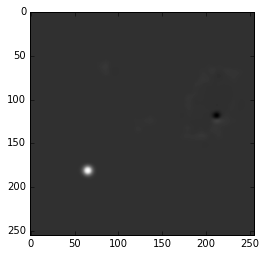

In [26]:
# If everything is done correctly, the imaginary part of S will be a machine precision residual
real_S = real(S)
real_fs = real(fourier_S)
maximum_S = amax(real_S)
minimum_S = amin(real_S)

plt.imshow(real_S, cmap="Greys_r")
cv2.imwrite('./Images/S.jpg', real_S)

In [27]:
# Global extrema of S are found just as an initial check
print("Maximum: " + str(maximum_S))
print("Points:")
for i in range(len(S)):
    for j in range(len(S)):
        if real_S[i][j] >= 0.99*maximum_S:
            print("(" + str(i) + "," + str(j) + ")")
print("Minimum: " + str(minimum_S))
print("Points:")
for i in range(len(S)):
    for j in range(len(S)):
        if real_S[i][j] <= 0.99*minimum_S:
            print("(" + str(i) + "," + str(j) + ")")

Maximum: 0.00103599996756
Points:
(181,65)
Minimum: -0.000193809793668
Points:
(118,211)


<h2>Finding D</h2>

Closed formula

In [28]:
denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    
denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
denom = sqrt(denom)
fourier_D = (F_r)*fourier_PSF_r*fourier_N
fourier_D = fourier_D - (F_n)*fourier_PSF_n*fourier_R
fourier_D = fourier_D/denom
D = ifft2(fourier_D)

True

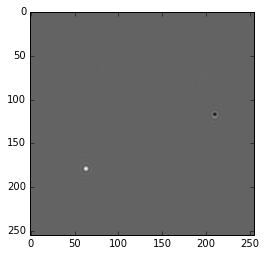

In [29]:
# If everything is done correctly, the imaginary part of D will be a machine precision residual
real_D = real(D)
real_fd = real(fourier_D)
maximum_D = amax(real_D)
minimum_D = amin(real_D)

plt.imshow(real_D, cmap="Greys_r")
cv2.imwrite('./Images/D.jpg', real_D)

In [30]:
# Global extrema of D are found just as an initial check
print("Maximum: " + str(maximum_D))
print("Points:")
for i in range(len(D)):
    for j in range(len(D)):
        if real_D[i][j] > 0.99*maximum_D:
            print("(" + str(i) + "," + str(j) + ")")
print("Minimum: " + str(minimum_D))
print("Points:")
for i in range(len(D)):
    for j in range(len(D)):
        if real_D[i][j] < 0.99*minimum_D:
            print("(" + str(i) + "," + str(j) + ")")

Maximum: 0.865700255283
Points:
(179,63)
Minimum: -0.407042063741
Points:
(117,209)


<h2>Transient Candidates</h2>

2.3472259528e-05


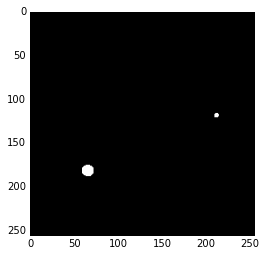

In [31]:
# As an alternative to finding local extrema, candidates are found by searching sources with significance greater 
# than a threshold. We are using 5 times the std of the image as the threshold.
# This is done because the method previously implemented to find local maxima is too sensitive to noise.

# The original S image should be used, not the rescaled one.
real_S = real(S)
sigma_S = std(real_S)
print(sigma_S)
candidates = zeros(shape(real_S))
for i in range(len(S)):
    for j in range(len(S)):
        if abs(real_S[i][j]) >= 5*sigma_S:
            candidates[i][j] = 255
plt.imshow(candidates, cmap="Greys_r")

In [32]:
candidates = measure.label(candidates)
for i in range(np.max(candidates)):
    x = str(average(np.where(candidates == (i + 1))[0]))
    y = str(average(np.where(candidates == (i + 1))[1]))
    print("Candidate " + str(i + 1) + ": (" + x + ", " + y + ")")

Candidate 1: (118.090909091, 210.909090909)
Candidate 2: (181.042253521, 65.0211267606)
